# Project: Sentiment Analysis

## Context

Sentiment analysis refers to classifying the sentiments that are expressed in the text source into positive and negative (and sometimes neutral). Tweets are often useful in generating a vast amount of sentiment data upon analysis. These data are useful in understanding the opinion of the people about a variety of topics.

Therefore we need to develop an NLP Sentiment Analysis Model in order to compute the customer perception.
 
In this project, we propose a real, large and public Tweet Sentiment Analysis dataset. The data contains tweets extracted using the twitter api. The tweets have been annotated (0 = negative, 4 = positive) and they can be used to detect sentiment.

Following the steps of this project, you will be able to:
* Understand the data structure
* Pre-porcess the dataset
* Train a recurrent neural network model to classify Tweets into positive/negative categories
* Evaluate the model performances on the test data

## Step 0: Load the Data

* In the next cell, you can import all the needed packages for later use.


In [1]:
## TO DO: 
# Add all the needed packages
import pandas as pd
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import nltk
from wordcloud import WordCloud
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import train_test_split

from keras.models import Model
from keras.layers import Activation, Dense, Dropout, Input, Embedding, LSTM
import tensorflow as tf
import numpy as np
from sklearn import preprocessing

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import keras


* Start first by loading the Sentiment Analysis dataset.


The dataset contains the following 6 fields:
* ids: The id of the tweet ( 2087)
* date: the date of the tweet (Sat May 16 23:58:44 UTC 2009)
* flag: The query (lyx). If there is no query, then this value is NO_QUERY.
* user: the user that tweeted (robotickilldozr)
* text: the text of the tweet (Lyx is cool)

Hint: To make your work easier, you are advised to transform the data into a Pandas dataframe and take the time to visualise and understand its content.

In [2]:
## TO DO: 
# Load the dataset into a Pandas dataframe
# Visualize the dataframe

file_name = 'tweet_data.csv'
df=pd.read_csv(file_name)
df.head()

,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
0,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
1,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew
2,0,1467811592,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,mybirch,Need a hug
3,0,1467811594,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,coZZ,@LOLTrish hey long time no see! Yes.. Rains a...
4,0,1467811795,Mon Apr 06 22:20:05 PDT 2009,NO_QUERY,2Hood4Hollywood,@Tatiana_K nope they didn't have it


* You can see the columns are without any proper names. Lets rename them for our reference

In [3]:
## TO DO: 
# Rename the columns referring to the 6 previously mentioned fields
# Visualize the dataframe

df.columns = ['annotation','id','date','flag','user','text']
df.head()

,annotation,id,date,flag,user,text
0,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
1,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew
2,0,1467811592,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,mybirch,Need a hug
3,0,1467811594,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,coZZ,@LOLTrish hey long time no see! Yes.. Rains a...
4,0,1467811795,Mon Apr 06 22:20:05 PDT 2009,NO_QUERY,2Hood4Hollywood,@Tatiana_K nope they didn't have it


We are going to train only on text to classify its sentiment. So we can ditch the rest of the useless columns.

In [4]:
## TO DO:
# Drop useless columns

df = df[["annotation","text"]]
df.head()

,annotation,text
0,0,"@nationwideclass no, it's not behaving at all...."
1,0,@Kwesidei not the whole crew
2,0,Need a hug
3,0,@LOLTrish hey long time no see! Yes.. Rains a...
4,0,@Tatiana_K nope they didn't have it


## Step 1: Data Exploration & Visualisation

* In this section, you are asked to provide a basic summary of the dataset in order to have a general idea about its components.

First the dataset is not randomly created. Start by randomizing it.

In [5]:
## TO DO:
# Creates random indexes to choose from dataframe
# Returns the rows with the index and display it

df = shuffle(df)
df #after randomizing (shuffle)

,annotation,text
2168,4,@ashleytisdale PLEASE!
704,0,"Change of plans, we ordered Macs instead. Time..."
1502,4,@sarahpittman You're welcome. Hope you had a ...
1552,4,@trianglman feel free to DM me if you'd rather...
714,0,@limbecky I'm doing the time warp without you ...
...,...,...
2013,4,@withinwithout hungover from the big time twee...
597,0,@birutagme yeah it was really depressing... s...
86,0,@Hollywoodheat I should have paid more attenti...
533,0,ill so i cant go to the cinema!!


* Follow the next cells intructions in order to explore the dataset

In [6]:
## TO DO:
# Provide the number of of the samples
# Provide the number of classes
# Provide the name of the classes

num_tweet = df.shape[0]
num_class = len(df["annotation"].unique()) 
name_class = df["annotation"].unique()

print("Number of total Tweets =  ", num_tweet)
print("Number of unique classes = ", num_class, ":", name_class)

Number of total Tweets =   2604
Number of unique classes =  2 : [4 0]


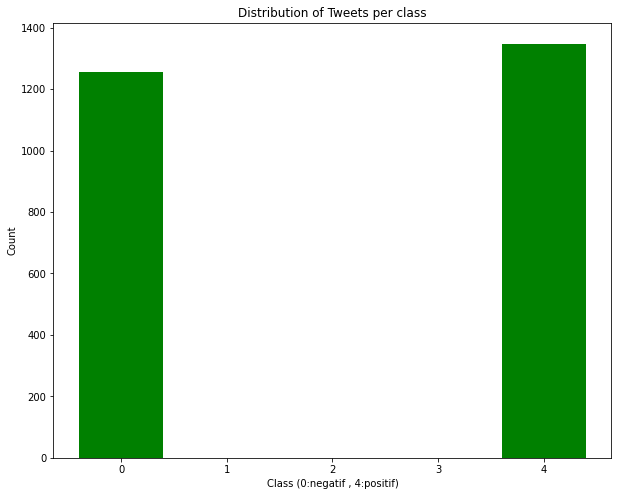

In [7]:
## TO DO:
# Create an informative plot to show the sms distribution per class
# Don't forget to annotate your plot: Add the the labels name, the title ...)

Count_per_class = df["annotation"].value_counts()
percentage_per_class = Count_per_class*100/num_tweet

fig = plt.figure(figsize=(10, 8))
bar_plot = plt.bar(name_class,Count_per_class,color='green')


plt.xlabel('Class (0:negatif , 4:positif)')
plt.ylabel('Count')
plt.title('Distribution of Tweets per class')
plt.show()



### Positive Words

In [8]:
dfPositif = df[df["annotation"] == 4]
dfPositif # dataframe with only positive tweets

,annotation,text
2168,4,@ashleytisdale PLEASE!
1502,4,@sarahpittman You're welcome. Hope you had a ...
1552,4,@trianglman feel free to DM me if you'd rather...
1617,4,"@bellaarsenault well, I wouldn't be talkin'. I..."
1540,4,Going home.
...,...,...
1543,4,@ThisIsRobThomas I think you should earn bonus...
2386,4,JBs NEW ALBUM and NEW YORK! I will check back...
1773,4,just back from a lovely day at school brain fr...
2013,4,@withinwithout hungover from the big time twee...


In [9]:
positifCorpus=' '.join(list(dfPositif["text"]))

<Figure size 1440x1440 with 0 Axes>

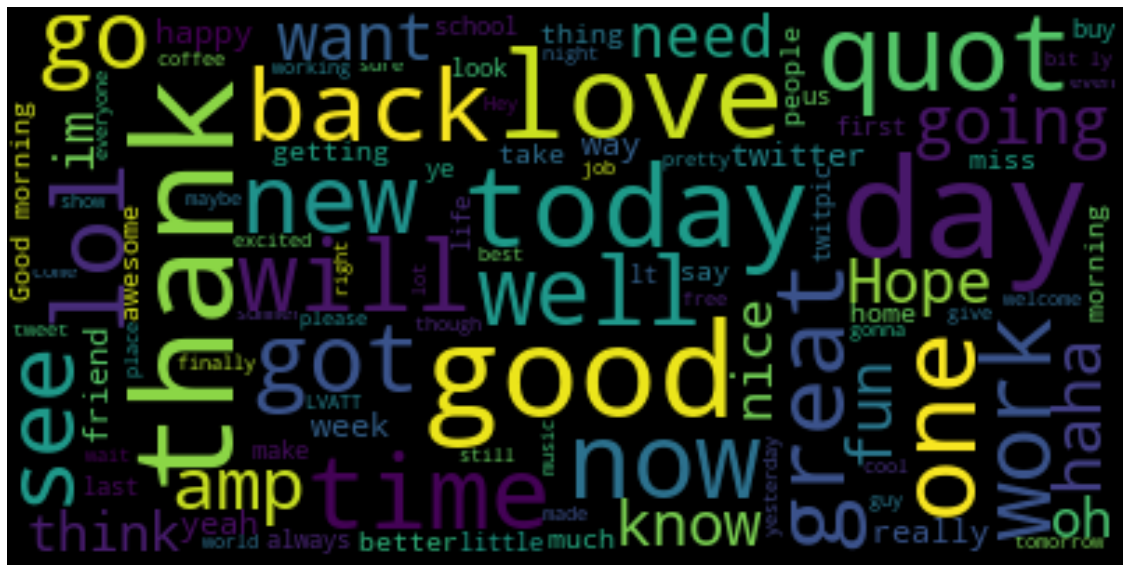

In [10]:
## TO DO:
# Create an informative plot to show the words distribution in the "positive" class
# Hint: WordCloud library is a good option here

plt.figure(figsize = (20,20)) 
# Create and generate a word cloud image:
wordcloud = WordCloud(max_font_size=50, max_words=100).generate(positifCorpus)
plt.figure(figsize = (20,20)) 
# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Negative Words

In [11]:
dfNegatif = df[df["annotation"] == 0]# dataframe with only neagtive tweets
dfNegatif

,annotation,text
704,0,"Change of plans, we ordered Macs instead. Time..."
714,0,@limbecky I'm doing the time warp without you ...
686,0,i just got a text from sarah
1164,0,looks like i've missed out on yet another job ...
157,0,is alone downstairs...working
...,...,...
692,0,"Just finished a delicious breakfast, my last i..."
177,0,Check out my mug http://www.erika-obscura.blo...
597,0,@birutagme yeah it was really depressing... s...
86,0,@Hollywoodheat I should have paid more attenti...


In [12]:
negatifCorpus=' '.join(list(dfNegatif["text"]))

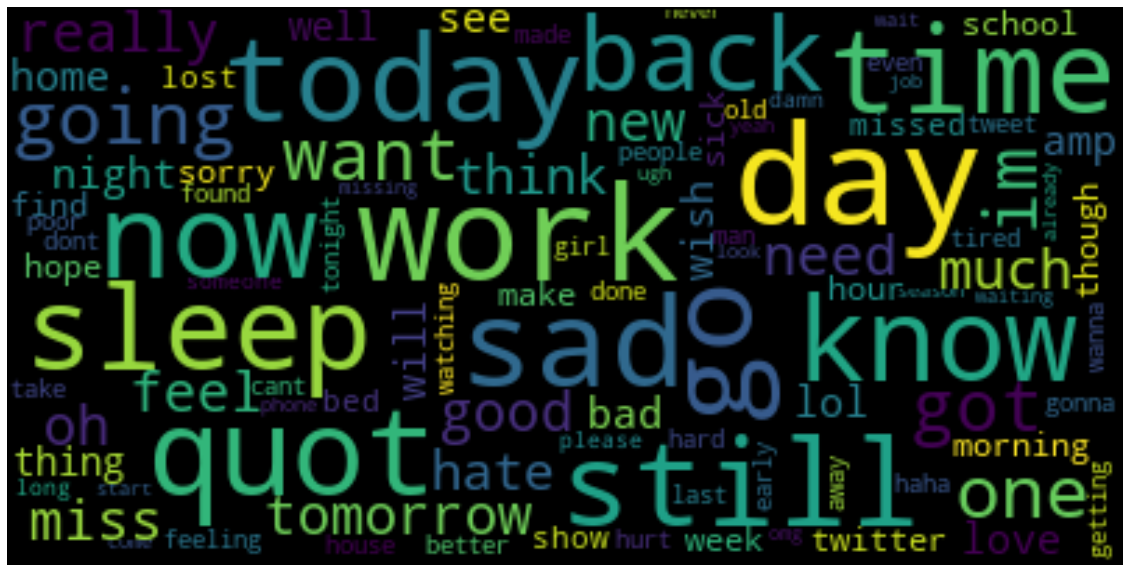

In [13]:
## TO DO:
# Create an informative plot to show the words distribution in the "negative" class
# Hint: WordCloud library is a good option here

plt.figure(figsize = (20,20)) 
# Create and generate a word cloud image:
wordcloud = WordCloud(max_font_size=50, max_words=100).generate(negatifCorpus)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


# Step 2: Data Pre-processing

Based on the data exploration $ visualization section, add any kind of pre-processing you think could help in the modelling part: Lowercasing, Lemmatization, Stop word removal, Punctuation removal ...



In [14]:
## TO DO:
# Do pre-processing of the text data
# Add as many cells as needed

### removing ponctuation

In [15]:
import re
import string
#remove punctuation ("'!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~'")
df['text'] = df['text'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '' , x))

### removing stopwords

In [16]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [17]:
#remove stopwords
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
stop_words.add('subject')
stop_words.add('http')
def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in stop_words])
df['text'] = df['text'].apply(lambda x: remove_stopwords(x))

### stemming

In [18]:
#stemming
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()
def stem_words(text):
    return " ".join([stemmer.stem(word) for word in text.split()])
df["text"] = df["text"].apply(lambda x: stem_words(x))

### Lemmitization

In [19]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [20]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
def lemmatize_words(text):
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])
df["text"] = df["text"].apply(lambda text: lemmatize_words(text))

In [21]:
df

,annotation,text
2168,4,ashleytisdal plea
704,0,chang plan order mac instead time hit book
1502,4,sarahpittman your welcom hope great weekend ca...
1552,4,trianglman feel free DM youd rather take whole...
714,0,limbecki Im time warp without sad
...,...,...
2013,4,withinwithout hungov big time tweetup parti lo...
597,0,birutagm yeah realli depress stuff like get
86,0,hollywoodheat I paid attent cover photoshop we...
533,0,ill cant go cinema






## Tokenization

In [22]:
X=df["text"]
y=df["annotation"]

In [23]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)

In [24]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 6405 unique tokens.


In [25]:
sequences = tokenizer.texts_to_sequences(X)

In [26]:
MAX_SEQUENCE_LENGTH = 30
X = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

In [27]:
X.shape

(2604, 30)

## Train and Test split

Split the dataset winto training and testing dataset. It's important to shuffle our dataset before training.

In [28]:
## TO DO:
# Split the dataset into train and test sets
# Again Sklearn package will help to the task

TRAIN_SIZE = 0.8
MAX_NB_WORDS = 10000
MAX_SEQUENCE_LENGTH = 30



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=0)

print("Train Data size:", len(X_train))
print("Test Data size", len(X_test))

Train Data size: 2083
Test Data size 521


## Tokenization 


**was done earlier**

*In* this section we would like to:

Tokenize the data and convert the text to sequences.
Set a max_length to your tokenizer.
Add padding to ensure that all the sequences have the same shape.

In [29]:
## TO DO:
# Add the pre-processing steps here
# Tokenize the data
# Set a max sequence length for the tokenizer
# Add padding to you sequences

# TOKENIZATION was done in the previous cells

print("Training X Shape:",X_train.shape)
print("Testing X Shape:",X_test.shape)

Training X Shape: (2083, 30)
Testing X Shape: (521, 30)


In [30]:
X_train

array([[   0,    0,    0, ..., 1060,   10,   66],
       [   0,    0,    0, ..., 5989,   36,  892],
       [   0,    0,    0, ..., 5699,  314,   66],
       ...,
       [   0,    0,    0, ...,  109,    5,  454],
       [   0,    0,    0, ...,   21,  281,  430],
       [   0,    0,    0, ...,  423,   17, 1459]], dtype=int32)

### Label Encoding 
We are building the model to predict class in enocoded form (0 or 1 as this is a binary classification). We should encode our training labels to encodings.

In [31]:
## TO DO:
# Extract input and output vectors
# Transform the labels to numbers
# Sklearn package provides usuful tools here

le =preprocessing.LabelEncoder()
y_train=le.fit_transform(y_train)
y_test=le.fit_transform(y_test)


y_train=y_train.reshape(-1,1)
y_test=y_test.reshape(-1,1)



print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (2083, 1)
y_test shape: (521, 1)


# Model Training
Define the recurrent neural network structure of your model. You can choose any kind of recurrent model you wish to use: Simple RNN, LSTM... Feel free to play around the number of layers, type of activation functions, hyper parameter values in order to get the best accuracy over the training and validation sets.

When the model performs well on the validation set, keep the configuration as your final model.

We are clear to build our Deep Learning model. While developing a DL model, we should keep in mind of key things like Model Architecture, Hyperparmeter Tuning and Performance of the model.


In [32]:
vocab_size = len(word_index)+1
output_dim = 32

In [33]:
## TO DO:
# Define the recurrent neural network model architecture
# Create a seperate funtion for that

def RNN():
    """
    Define the RNN function
    """
    max_len=30
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(vocab_size,50,input_length=max_len)(inputs)
    layer = LSTM(128)(layer) 
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    
    layer = Dense(64,name='FC2')(layer)
    layer = Activation('relu')(layer)
    

    

    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model


In [34]:
## TO DO:
# Call and compile the model

LR = 1e-3
BATCH_SIZE = 16
EPOCHS = 10
model = RNN()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR),loss="binary_crossentropy", metrics=["accuracy"])
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 30)]              0         
                                                                 
 embedding (Embedding)       (None, 30, 50)            320300    
                                                                 
 lstm (LSTM)                 (None, 128)               91648     
                                                                 
 FC1 (Dense)                 (None, 256)               33024     
                                                                 
 activation (Activation)     (None, 256)               0         
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 FC2 (Dense)                 (None, 64)                16448 

In [35]:
## TO DO:
# Fit on the training data
# Try multiple batch_size, epochs, validation_split ... 
# and see the difference between the results

history=model.fit(X_train,y_train,batch_size=64,epochs=EPOCHS,validation_split=0.2)

#history = ...

Epoch 1/10
27/27 [==============================] - 11s 195ms/step - loss: 0.6932 - accuracy: 0.4946 - val_loss: 0.6906 - val_accuracy: 0.5276
Epoch 2/10
27/27 [==============================] - 4s 141ms/step - loss: 0.6688 - accuracy: 0.6285 - val_loss: 1.1995 - val_accuracy: 0.5252
Epoch 3/10
27/27 [==============================] - 3s 114ms/step - loss: 0.5240 - accuracy: 0.8043 - val_loss: 0.5997 - val_accuracy: 0.6835
Epoch 4/10
27/27 [==============================] - 2s 69ms/step - loss: 0.1880 - accuracy: 0.9328 - val_loss: 0.9135 - val_accuracy: 0.6835
Epoch 5/10
27/27 [==============================] - 2s 70ms/step - loss: 0.0661 - accuracy: 0.9814 - val_loss: 1.0676 - val_accuracy: 0.7170
Epoch 6/10
27/27 [==============================] - 2s 70ms/step - loss: 0.0343 - accuracy: 0.9898 - val_loss: 1.1211 - val_accuracy: 0.6835
Epoch 7/10
27/27 [==============================] - 2s 70ms/step - loss: 0.0097 - accuracy: 0.9976 - val_loss: 1.4808 - val_accuracy: 0.7026
Epoch 8/1

# Model Evaluation
Now that we have trained the model, we can evaluate its performance. We will some evaluation metrics and techniques to test the model.

Let's start with the Learning Curve of loss and accuracy of the model on each epoch.

In [36]:
## TO DO:
# Evaluate to model on the test set
# Print the test accuracy results
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 70.63%


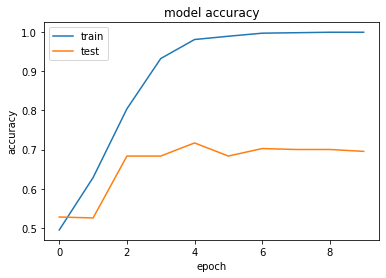

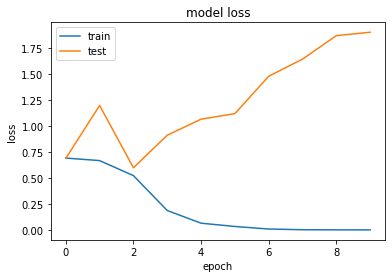

In [37]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Improvements
Finally the floor is yours to add whatever improvements you're thinking about. If your model is presenting some learning issues like overfitting you can dedicate this part to introducing some techniques to reduce overfitting and show the improvements.